# Calculate Sobol Indices of different orthogonality measures

In [2]:
%run imports.py

seed = 4
np.random.seed(seed)
tf.random.set_seed(seed)

All packages loaded successfully.


In [3]:
# --- Generate synthetic 2D data ---
def true_function(X):
    x1, x2 = X[:,0], X[:,1]
    return np.exp(-(x1-1.2)**2) + np.exp(-(x2+1.2)**2)


n = 1000
noise = 0.01
X = np.random.normal(1.2, 1, size=(n,2))
y = true_function(X) + np.random.normal(0, noise, size=n)

y = y.reshape(-1, 1)
y_mean, y_std = np.mean(y), np.std(y)
y = (y - y_mean) / y_std

In [4]:
print("OAK with a Gaussian Measure N(1.2,1) ...")
custom_measure = MOGMeasure(means=np.array([1.2]), variances=np.array([1.0]), weights=np.array([1.0]))
gmm_measures_list = [custom_measure, custom_measure]


# --- Create AGP model ---
data = (X, y)
model = create_model_oak(
         data=data,
         max_interaction_depth=2,
         constrain_orthogonal=True,
         share_var_across_orders=True,
         use_sparsity_prior=False,
         gmm_measures=gmm_measures_list,
)
for i in range(X.shape[1]):
    model.kernel.kernels[i].base_kernel.variance.assign(1.0)
    gpflow.set_trainable(model.kernel.kernels[i].base_kernel.variance, False)


# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))


# --- Print model summary ---
gpflow.utilities.print_summary(model)
print(model.training_loss().numpy())




print("OAK with a Gaussian Measure N(-1.2,1) ...")
custom_measure = MOGMeasure(means=np.array([-1.2]), variances=np.array([1.0]), weights=np.array([1.0]))
gmm_measures_list = [custom_measure, custom_measure]


# --- Create AGP model ---
data = (X, y)
model1 = create_model_oak(
         data=data,
         max_interaction_depth=2,
         constrain_orthogonal=True,
         share_var_across_orders=True,
         use_sparsity_prior=False,
         gmm_measures=gmm_measures_list,
)
for i in range(X.shape[1]):
    model1.kernel.kernels[i].base_kernel.variance.assign(1.0)
    gpflow.set_trainable(model1.kernel.kernels[i].base_kernel.variance, False)


# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model1.training_loss, model1.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))


# --- Print model summary ---
gpflow.utilities.print_summary(model1)
print(model1.training_loss().numpy())



print("OAK with an Empirical Measure ...")
empirical_locations_list = []
empirical_weights_list = []

for dim in range(X.shape[1]):
    # Calculate locations and weights for the current dimension
    locations, counts = np.unique(X[:, dim], return_counts=True)
    weights = (counts / counts.sum()).reshape(-1, 1)
    locations = locations.reshape(-1, 1)
    
    # Append the results to our lists
    empirical_locations_list.append(locations)
    empirical_weights_list.append(weights)


data = (X, y)
model2 = create_model_oak(
        data=data,
        max_interaction_depth=2,
        constrain_orthogonal=True,
        share_var_across_orders=True,
        use_sparsity_prior=False,
        empirical_locations=empirical_locations_list,
        empirical_weights=empirical_weights_list,
)
for i in range(X.shape[1]):
    model1.kernel.kernels[i].base_kernel.variance.assign(1.0)
    gpflow.set_trainable(model1.kernel.kernels[i].base_kernel.variance, False)


# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model2.training_loss, model2.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))


# --- Print model summary ---
gpflow.utilities.print_summary(model2)
print(model2.training_loss().numpy())

OAK with a Gaussian Measure N(1.2,1) ...
╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].base_kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1           │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.985812    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼────

In [5]:

# Calculate the Sobol indices
tuple_of_indices, sobols = compute_sobol_oak_with_mog(model,share_var_across_orders=True)
normalised_sobols = sobols / np.sum(sobols)

print("--- Sobol Analysis for N(1.2,1) Model ---")
for indices, sobol_value, normalised_sobol in zip(tuple_of_indices, sobols, normalised_sobols):
    feature_name = " & ".join([f"Feature {i+1}" for i in indices])
    print(f"Effect: {feature_name}")
    print(f"  Sobol Index: {sobol_value:.4f}")
    print(f"  Normalised Sobol Index: {normalised_sobol:.4f}\n")
print("-------------------------------------")


# Calculate the Sobol indices
tuple_of_indices, sobols = compute_sobol_oak_with_mog(model1,share_var_across_orders=True)
normalised_sobols = sobols / np.sum(sobols)

print("--- Sobol Analysis for N(-1.2,1) Model ---")
for indices, sobol_value, normalised_sobol in zip(tuple_of_indices, sobols, normalised_sobols):
    feature_name = " & ".join([f"Feature {i+1}" for i in indices])
    print(f"Effect: {feature_name}")
    print(f"  Sobol Index: {sobol_value:.4f}")
    print(f"  Normalised Sobol Index: {normalised_sobol:.4f}\n")
print("-------------------------------------")


mu = 2.0
delta = 1.0
# Calculate the Sobol indices
tuple_of_indices, sobols = compute_sobol_oak(model2,delta=delta, mu=mu,share_var_across_orders=True)
normalised_sobols = sobols / np.sum(sobols)

print("--- Sobol Analysis for Empirical Model ---")
for indices, sobol_value, normalised_sobol in zip(tuple_of_indices, sobols, normalised_sobols):
    feature_name = " & ".join([f"Feature {i+1}" for i in indices])
    print(f"Effect: {feature_name}")
    print(f"  Sobol Index: {sobol_value:.4f}")
    print(f"  Normalised Sobol Index: {normalised_sobol:.4f}\n")
print("-------------------------------------")


--- Sobol Analysis for N(1.2,1) Model ---
Effect: Feature 1
  Sobol Index: 0.7913
  Normalised Sobol Index: 0.7518

Effect: Feature 2
  Sobol Index: 0.2612
  Normalised Sobol Index: 0.2482

Effect: Feature 1 & Feature 2
  Sobol Index: 0.0000
  Normalised Sobol Index: 0.0000

-------------------------------------
--- Sobol Analysis for N(-1.2,1) Model ---
Effect: Feature 1
  Sobol Index: 0.2521
  Normalised Sobol Index: 0.2455

Effect: Feature 2
  Sobol Index: 0.7747
  Normalised Sobol Index: 0.7545

Effect: Feature 1 & Feature 2
  Sobol Index: 0.0000
  Normalised Sobol Index: 0.0000

-------------------------------------


<unknown>:5: SyntaxWarning: invalid escape sequence '\s'


--- Sobol Analysis for Empirical Model ---
Effect: Feature 1
  Sobol Index: 0.7379
  Normalised Sobol Index: 0.7483

Effect: Feature 2
  Sobol Index: 0.2481
  Normalised Sobol Index: 0.2517

Effect: Feature 1 & Feature 2
  Sobol Index: 0.0000
  Normalised Sobol Index: 0.0000

-------------------------------------


C:\Users\jacks\AppData\Local\Temp\ipykernel_31016\1564444912.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


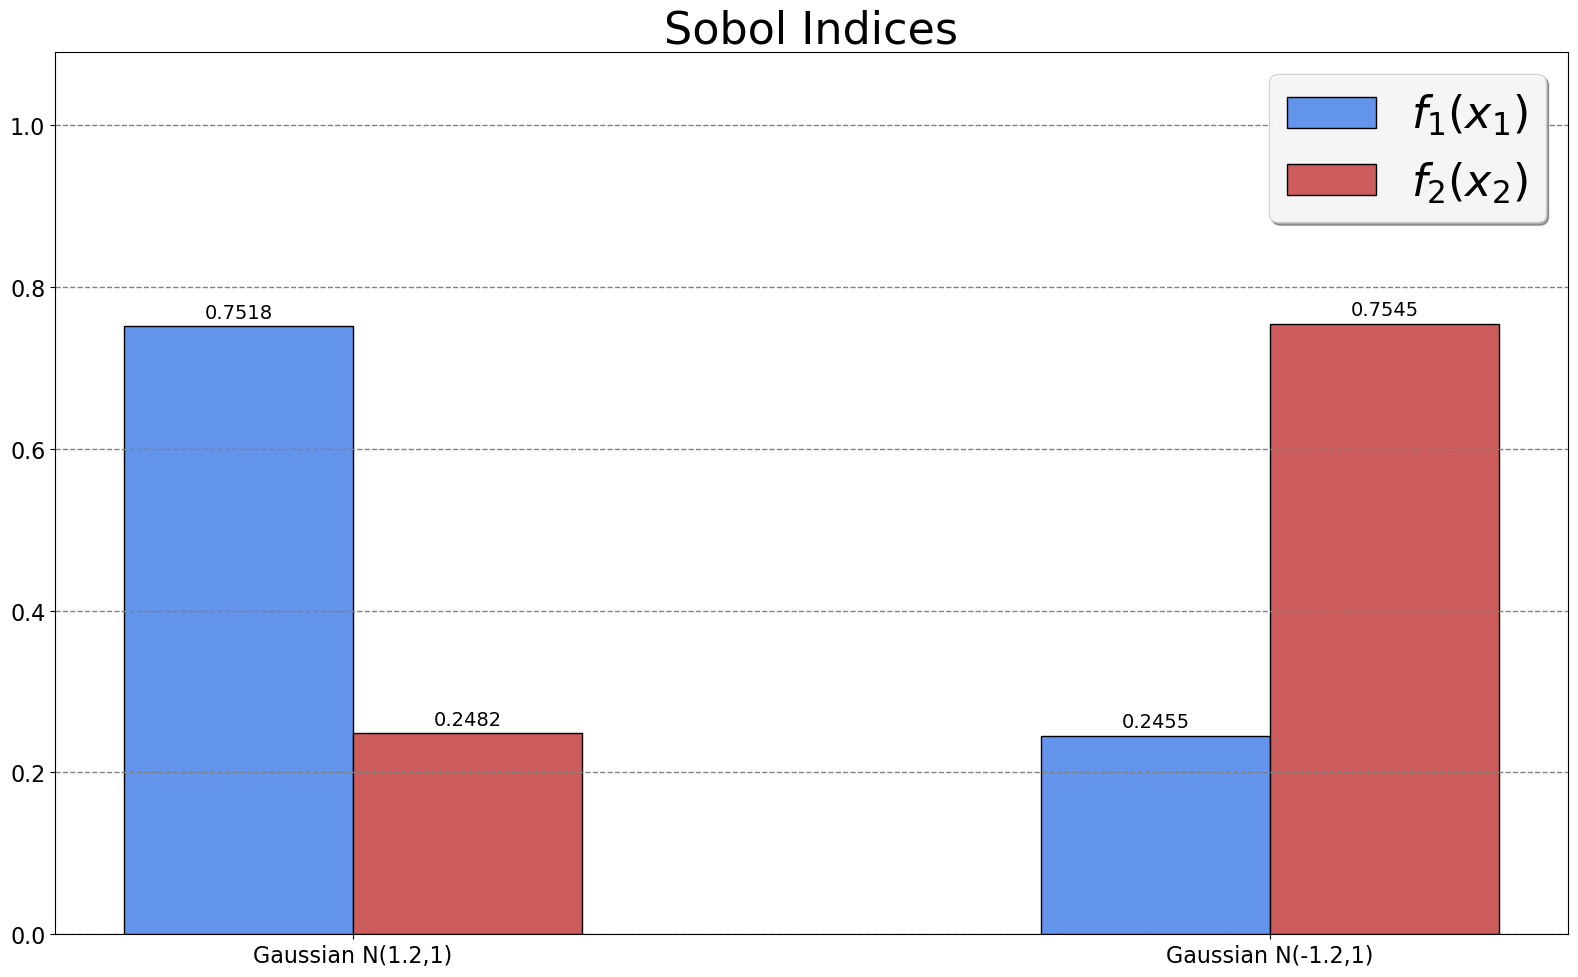

In [6]:
distributions = ("Gaussian N(1.2,1)", "Gaussian N(-1.2,1)")
sobol_first_orders = {
    '$f_1(x_1)$': (0.7518, 0.2455),
    '$f_2(x_2)$': (0.2482, 0.7545),
}

x = np.arange(len(distributions))
width = 0.25
multiplier = 0
colors = ['cornflowerblue', 'indianred']

fig, ax = plt.subplots(layout='constrained', figsize=(16,10))

for attribute, measurement in sobol_first_orders.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[multiplier], edgecolor='black')
    ax.bar_label(rects, padding=3)
    multiplier += 1


ax.set_title('Sobol Indices')
ax.set_xticks(x + width/2, distributions)
ax.set_ylim([0,1.09])
ax.grid(axis='y')
ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, framealpha=0.9, fontsize=32)

plt.tight_layout()
plt.show()